In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
# Options
sns.set_style("whitegrid")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', -1)

In [3]:
train = pd.read_csv("./data/input_data/train.csv")
test = pd.read_csv("./data/input_data/test.csv")

In [4]:
train_ID = train['Id']
train.drop("Id", axis = 1, inplace = True)
test_ID = test['Id']
test.drop("Id", axis = 1, inplace = True)

In [5]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

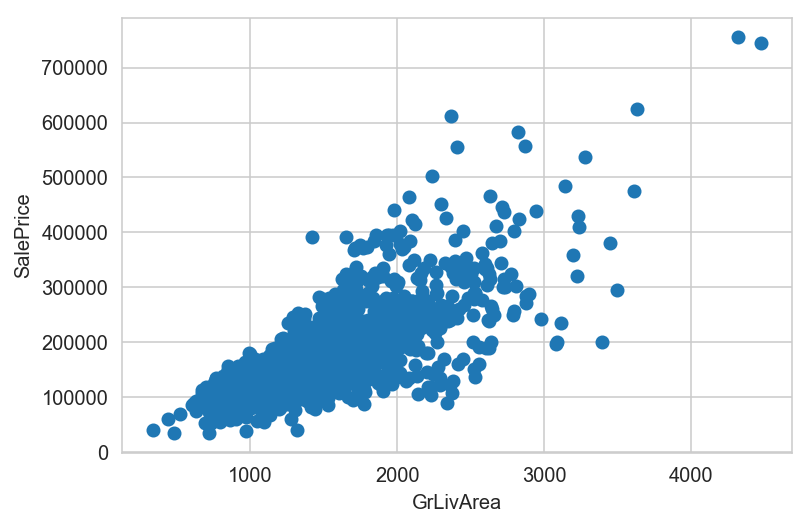

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=10)
plt.xlabel('GrLivArea', fontsize=10)
plt.show()


 mu = 180932.92 and sigma = 79467.79



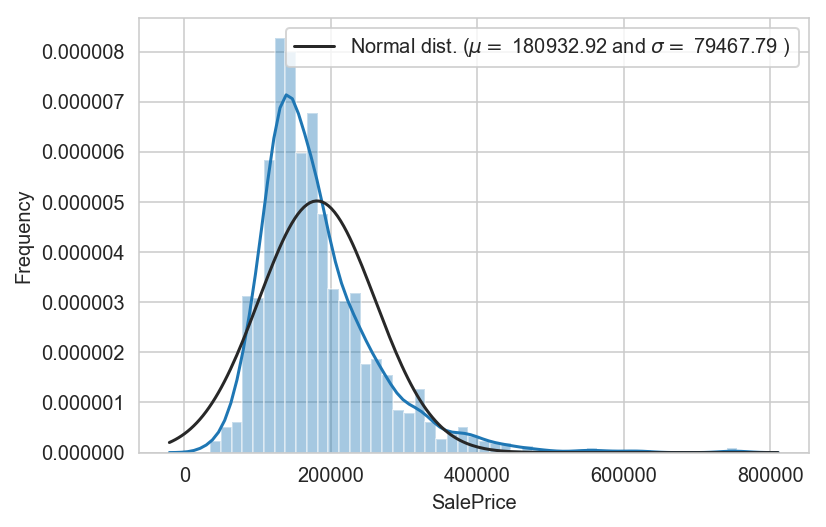

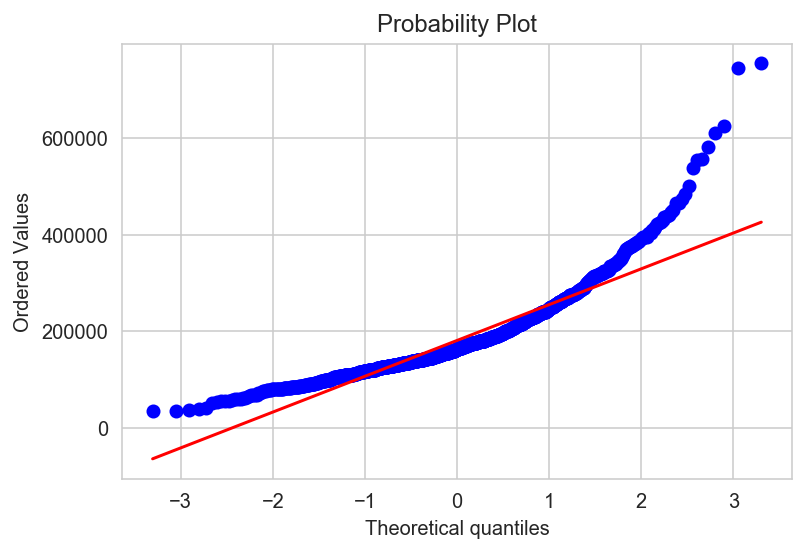

In [124]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [125]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [126]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [127]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Ratio' :all_data_na})
missing_data.head(25)

,Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


In [128]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

In [129]:
# Filling nas with None
for col in ("MasVnrType", 'MSSubClass', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [130]:
# Filling nan with 0
for col in ("MasVnrArea", 'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
            'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [131]:
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [132]:
# Filling ns with the mode
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [133]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Ratio' :all_data_na})
missing_data.head()

,Ratio


In [136]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
      
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [137]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.000,0.000,2,6,1.000,0.000,2,150.000,1,Norm,Norm,SBrkr,0,4,2,VinylSd,VinylSd,4,3,0,PConc,2,6,548.000,2.000,5,2,5,Attchd,2003.000,1710,1,GasA,0,2Story,1,2,Lvl,0,8450,Inside,65.000,3,0,5,RL,196.000,BrkFace,None,0,1,CollgCr,61,4,7,2,0,3,CompShg,Gable,Normal,WD,0,1,8,856.000,0,2003,2003,2
1,1262,0,0,1,3,1Fam,4,1,978.000,0.000,0,6,0.000,1.000,2,284.000,1,Feedr,Norm,SBrkr,0,4,3,MetalSd,MetalSd,4,5,1,CBlock,2,6,460.000,2.000,5,2,5,Attchd,1976.000,1262,0,GasA,0,1Story,1,3,Lvl,0,9600,FR2,80.000,3,0,0,RL,0.000,None,None,0,4,Veenker,0,7,6,2,0,3,CompShg,Gable,Normal,WD,0,1,6,1262.000,298,1976,1976,1
2,920,866,0,1,3,1Fam,4,2,486.000,0.000,2,6,1.000,0.000,2,434.000,1,Norm,Norm,SBrkr,0,4,2,VinylSd,VinylSd,4,5,1,PConc,2,6,608.000,2.000,5,2,5,Attchd,2001.000,1786,1,GasA,0,2Story,1,2,Lvl,0,11250,Inside,68.000,0,0,5,RL,162.000,BrkFace,None,0,8,CollgCr,42,4,7,2,0,3,CompShg,Gable,Normal,WD,0,1,6,920.000,0,2001,2002,2
3,961,756,0,1,3,1Fam,1,3,216.000,0.000,0,6,1.000,0.000,4,540.000,1,Norm,Norm,SBrkr,272,4,3,Wd Sdng,Wd Shng,4,2,1,BrkTil,1,6,642.000,3.000,5,3,5,Detchd,1998.000,1717,0,GasA,2,2Story,1,2,Lvl,0,9550,Corner,60.000,0,0,6,RL,0.000,None,None,0,1,Crawfor,35,4,7,2,0,3,CompShg,Gable,Abnorml,WD,0,1,7,756.000,0,1915,1970,0
4,1145,1053,0,1,4,1Fam,4,0,655.000,0.000,2,6,1.000,0.000,2,490.000,1,Norm,Norm,SBrkr,0,4,2,VinylSd,VinylSd,4,5,1,PConc,2,6,836.000,3.000,5,2,5,Attchd,2000.000,2198,1,GasA,0,2Story,1,2,Lvl,0,14260,FR2,84.000,0,0,5,RL,350.000,BrkFace,None,0,11,NoRidge,84,4,8,2,0,3,CompShg,Gable,Normal,WD,0,1,9,1145.000,192,2000,2000,2


In [135]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,TA,No,706.000,0.000,GLQ,Unf,1.000,0.000,Gd,150.000,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,None,0,PConc,2,Typ,548.000,2.000,TA,RFn,TA,Attchd,2003.000,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.000,Reg,0,60,RL,196.000,BrkFace,None,0,2,CollgCr,61,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,8,856.000,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,TA,Gd,978.000,0.000,ALQ,Unf,0.000,1.000,Gd,284.000,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,None,TA,1,CBlock,2,Typ,460.000,2.000,TA,RFn,TA,Attchd,1976.000,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.000,Reg,0,20,RL,0.000,None,None,0,5,Veenker,0,8,6,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,6,1262.000,298,1976,1976,2007
2,920,866,0,None,3,1Fam,TA,Mn,486.000,0.000,GLQ,Unf,1.000,0.000,Gd,434.000,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,TA,1,PConc,2,Typ,608.000,2.000,TA,RFn,TA,Attchd,2001.000,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.000,IR1,0,60,RL,162.000,BrkFace,None,0,9,CollgCr,42,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,6,920.000,0,2001,2002,2008
3,961,756,0,None,3,1Fam,Gd,No,216.000,0.000,ALQ,Unf,1.000,0.000,TA,540.000,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,None,Gd,1,BrkTil,1,Typ,642.000,3.000,TA,Unf,TA,Detchd,1998.000,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.000,IR1,0,70,RL,0.000,None,None,0,2,Crawfor,35,5,7,Y,0,None,CompShg,Gable,Abnorml,WD,0,Pave,7,756.000,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,TA,Av,655.000,0.000,GLQ,Unf,1.000,0.000,Gd,490.000,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,TA,1,PConc,2,Typ,836.000,3.000,TA,RFn,TA,Attchd,2000.000,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.000,IR1,0,60,RL,350.000,BrkFace,None,0,12,NoRidge,84,5,8,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,9,1145.000,192,2000,2000,2008


In [33]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [141]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 58 skewed numerical features to Box Cox transform


In [142]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 219)


In [143]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [144]:
X_train

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.693,11.686,0.000,0.730,1.541,1.820,1.541,11.170,0.000,1.194,2.260,0.730,0.000,1.194,7.483,0.730,0.000,1.820,1.194,1.820,1.541,0.000,1.194,2.260,10.506,1.194,2.056,1.194,2.056,14.188,13.699,0.730,0.000,0.730,1.194,0.000,19.212,5.831,1.541,0.000,2.056,8.059,0.000,0.730,5.715,1.820,2.440,1.194,0.000,1.541,0.000,0.730,2.603,11.693,0.000,14.188,14.188,1.194,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,

In [37]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [38]:
model_ridge = Ridge()

In [39]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

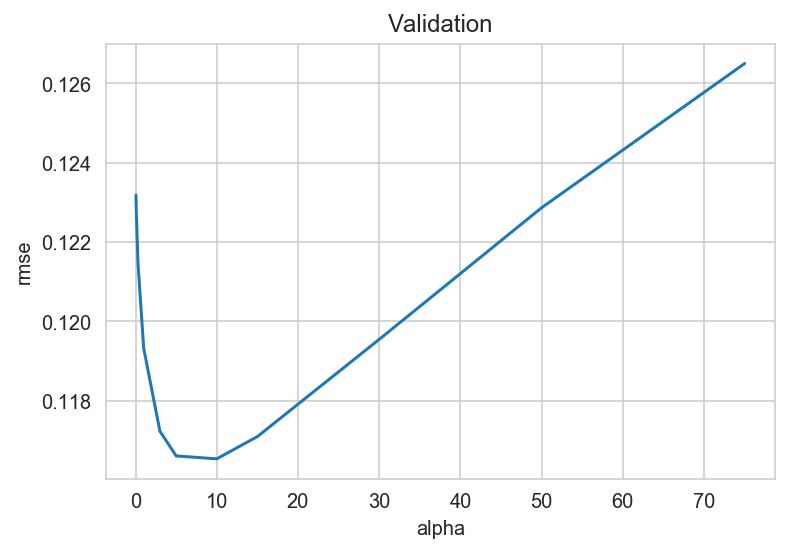

In [40]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [45]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=20).fit(X_train, y)

In [46]:
rmse_cv(model_lasso).mean()

0.11476482214397439

In [47]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [48]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

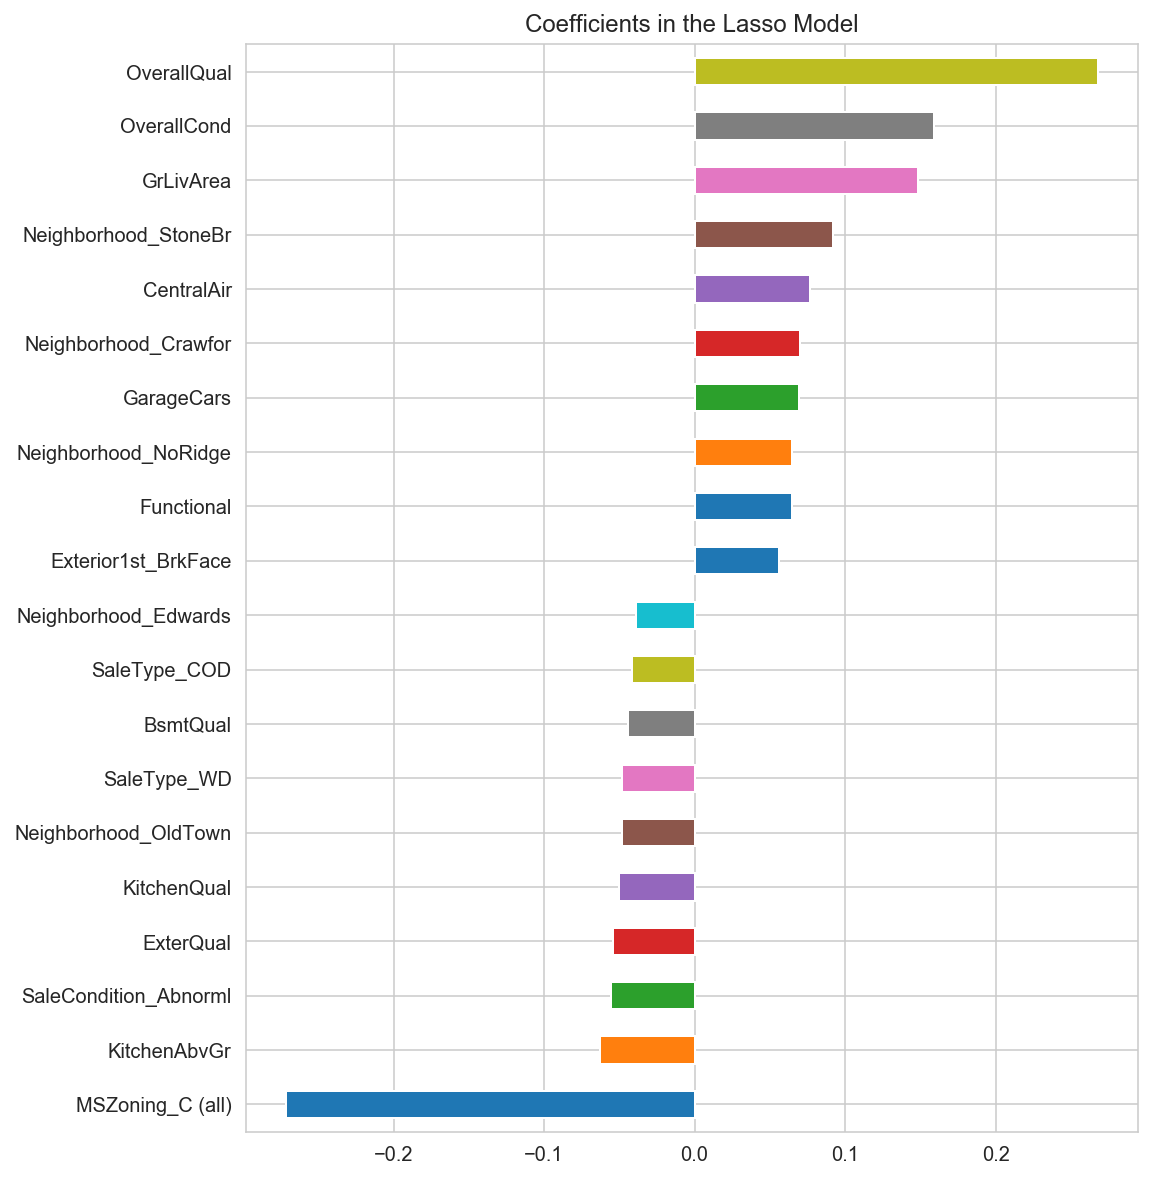

In [49]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [54]:
df_sub = pd.DataFrame()
df_sub['Id'] = test_ID
predictions = model_lasso.predict(X_test)
df_sub['SalePrice'] = np.expm1(predictions)
df_sub.to_csv('./data/output_data/lasso_submission_3.csv', index=False)

In [55]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

In [57]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [64]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [66]:
df_sub = pd.DataFrame()
df_sub['Id'] = test_ID
df_sub['SalePrice'] = xgb_preds
df_sub.to_csv('./data/output_data/lasso_submission_3.csv', index=False)